In this homework, you need to solve four tasks. The assignment should be uploaded in Jupyter Notebook format(`.ipynb`). Overall, there are 23 points, however, you can get a maximum of 20 points for this assignment( `your_points = min(your_points, 20)`). No bonus points will be transferred to the next assignment.

# Task 1. Non-parametric Density Estimation (6 points)

In [45]:
import numpy as np
import numpy.linalg as nla
import scipy
import scipy.stats
import pandas as pd

from statsmodels.nonparametric.kernel_regression import KernelReg

In [46]:
import pandas as pd
import numpy as np
import scipy.stats as sps

from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn.neighbors import KernelDensity
from sklearn.metrics.pairwise import rbf_kernel

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from statsmodels.nonparametric.kernel_regression import KernelReg

In [47]:
# Matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


# non-interactive
%matplotlib inline

#jupyterlab
# %matplotlib widget 

#jupyter-notebook
# %matplotlib notebook 

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

You will work with data sampled from the mixture of Normal distributions:

In [48]:
seed1 = 31337
seed2 = 42
n_samples = 100

f1 = scipy.stats.norm(loc=0, scale=1)
f2 = scipy.stats.norm(loc=5, scale=1)
p1 = 0.3
p2 = 1 - p1

Xa = f1.rvs(size=int(p1 * n_samples), random_state=seed1)
Xb = f2.rvs(size=int(p2 * n_samples), random_state=seed2)
samples = np.concatenate([Xa, Xb])

a = -5
b = 10

x_values = np.linspace(a, b, 1000)
binedges = np.linspace(a, b, 10)
true_pdf = p1 * f1.pdf(x_values) + p2 * f2.pdf(x_values)

## Histogram estimate

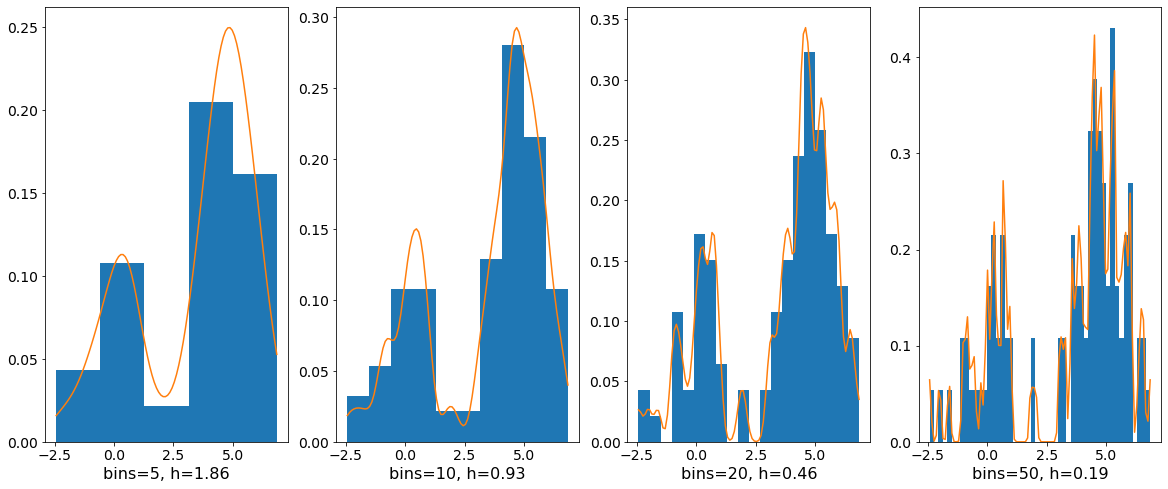

In [49]:
bin_list = [5, 10, 20, 50]

sample_min, sample_max = np.min(samples), np.max(samples)
delta = sample_max - sample_min

grid = np.linspace(sample_min, sample_max, 100)

fig, axes = plt.subplots(1, len(bin_list), figsize=(20, 8))
for ax, bins in zip(axes, bin_list):
    
    ax.hist(samples, bins=bins, density=True)
    
    h = delta / bins / 3
    density = KernelDensity(kernel="gaussian", bandwidth=h).fit(samples[:, None])
    ax.plot(grid, np.exp(density.score_samples(grid[:, None])))
    ax.set_xlabel(f"bins={bins}, h={delta / bins:.2f}")


$\newcommand{\boldX}{\boldsymbol{X}}$
$\newcommand{\xs}[1]{\boldX^{(#1)}}$
$\newcommand{\Sum}{\sum\limits}$
$\newcommand{\Int}{\int\limits}$
$\newcommand{\hatp}{\widehat{p}}$
$\newcommand{\hatJ}{\widehat{J}}$
$\newcommand{\lp}{\left(}$
$\newcommand{\rp}{\right)}$

Given a sample $\boldsymbol{X}^{(n)} = \boldsymbol{X}_1, \boldsymbol{X}_2, ..., \boldsymbol{X}_n \sim \; iid \; p(x)$ we would like to build a hitogram estimate of the density. If we have $m$ bins of size $h$, we can have the following estimates of risk using leave-one-out cross validation:

\begin{gather*}
J(h) = \int \hatp^2\lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx, 
\end{gather*}
\begin{gather*}
\hatJ(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - \frac{2}{n}\Sum_{i = 1}^n \hatp \lp \boldsymbol{X}_i ;\xs{n\backslash i} \rp, \label{eq1}\tag{1}
\end{gather*}
\begin{gather*}
\hatJ(h) = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n}. \label{eq2}\tag{2}
\end{gather*}

Your task is:
1. Build a histogram estimate of the pdf given the sample above, tune bandwidth using leave-one-out CV. Use formula (\ref{eq2}). Also check out `np.histogram` (1 point)
2.\* Prove that for histograms (\ref{eq2}) follows from (\ref{eq1}) (1 bonus point)
3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)
4. Recall the approximation to $MISE$ from Lecture 7, slides 11-13. Assume an Oracle calculated the integral of the squared derivative of the true density for you and the value is $0.0804924$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)
5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [50]:
def cross_validation_histogram_2(sample, h):
    n = len(sample)
    sample_min, sample_max = np.min(sample), np.max(sample)
    bins = np.int(np.ceil((sample_max - sample_min) / h))
    p = np.histogram(sample, bins=bins, range=(sample_min, sample_max), density=False)[0]
    summ = np.sum([(p[i] / n)**2 for i in range(len(p))])
    summa = 2/((n-1)*h) - (n+1)/((n-1)*h)*summ
    return summa

In [51]:
h_list1 = np.logspace(-3,3, 10000)
cv_hist1 = [cross_validation_histogram_2(samples, hi) for hi in h_list1]


In [52]:
b = h_list1[np.argmin(cv_hist1)]

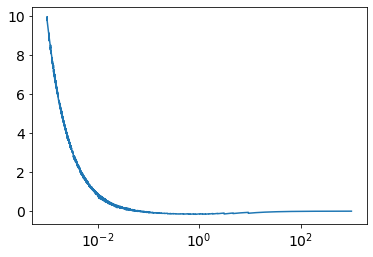

In [53]:
#diff = [cv_hist[i] - cv_hist1[i] for i in range (len(cv_hist))]
plt.plot(h_list1, cv_hist1)
#plt.vlines(b,-0.1,25, color= 'r')
plt.xscale("log")

In [54]:
print('h_cv', b, '\n', 'J', min(cv_hist1), '\n', 'num of bins', 11)

h_cv 0.8442919515616993 
 J -0.1619167993395947 
 num of bins 11


3. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$ (0.5 point)

In [55]:
const = 0.0804924
h_b = 1/(len(samples)**(1/3))*(6/const)**(1/3)
print('h_cv', h_b, '\n', 'J', cross_validation_histogram_2(samples, h_b))

h_cv 0.9067038459825565 
 J -0.1507714466093491


5. `np.histogram` has some built-in methods of selecting bandwidth. Compare some of them with your result and theoretical approximation (again, using CV estimate of $J$) (1 point)

In [56]:

method = ['auto', 'fd', 'scott', 'rice', 'sturges', 'sqrt']

for i in range(6):
    hist, bin_edges = np.histogram(samples, bins = method[i])
    h = (max(samples) - min(samples))/len(hist)
    print(method[i], h)


auto 1.1603132405929415
fd 1.8565011849487063
scott 1.5470843207905887
rice 0.9282505924743532
sturges 1.1603132405929415
sqrt 0.9282505924743532


Prove that for histograms ( 2 ) follows from ( 1 )

1) $A = \int \hatp^2\lp x;\xs{n} \rp dx = \int \frac{1}{n^2h^2}(\sum\limits_{i=1}^m(\nu_i \mathbf{1}\{x\in \Delta_i \})^2 = \int \frac{1}{n^2h^2}\sum\limits_{i=1}^m \nu_i^2 \mathbf{1}\{x\in \Delta_i \} = \frac{1}{h^2n^2}\sum\limits_{i=1}^m \nu_i^2 h$ and as we have $\nu_i$ - he number of samples that fell into $\Delta_i$ $\rightarrow A = \frac{\sum\limits_{i=1}^m p_i^2}{h}$

2) $B = -\frac{2}{n} \int \hatp \lp x;\xs{n} \rp p(x)$

When we consider $\int \hatp \lp x;\xs{n} \rp$ we have $\frac{1}{(n-1)h}(n_i-1)$

$B = -\frac{2}{n}\big(\frac{\sum\limits_{i=1}^m n_i^2}{(n-1)h} - \frac{n}{(n-1)h} \big) = \frac{2}{(n-1)h} - 2n\frac{\sum\limits_{i=1}^m n_i^2}{(n-1)h}$


$\hatJ(h) = A+B = \frac{\sum\limits_{i=1}^m p_i^2}{h} + \frac{2}{(n-1)h} - 2n\frac{\sum\limits_{i=1}^m n_i^2}{(n-1)h} = \frac{2}{(n - 1)h} - \frac{n+1}{(n-1)h}\Sum_{i = 1}^m \hatp_j^2,\quad \hatp_j = \frac{n_j}{n} $

## Kernel density estimate

In this part, you will use the same sample, but employ the kernel density estimation method. We can use the same proxy expression to optimise the risk:
\begin{gather*}
J(h) = \int \hatp^2 \lp x;\xs{n} \rp dx - 2 \int \hatp \lp x;\xs{n} \rp p(x) dx
\end{gather*}

In out case of kernel estimator, we can obtain:
\begin{gather*}
\hatJ(h) = \frac{1}{hn^2}\Sum_{i = 1}^n\Sum_{j = 1}^n K^{(2)}\lp\frac{x_i - x_j}{h}\rp + \frac{2K(0)}{nh}, \label{eq3}\tag{3}
\end{gather*}
where
\begin{gather*}
K^{(2)}(x) = K^*(x) - 2K(x), \quad K^*(x) = \int K(x - y) K(y) dy.
\end{gather*}

You can use [kernel density estimation from sklearn](http://scikit-learn.org/stable/modules/density.html). Your task is:
1. Build a kernel density estimate given the sample from before, tune bandwidth using leave-one-out CV. Try two different kernels of your choice. Use formula \ref{eq3} for your estimates (1 point)
2. Plot CV estimates $\hatJ(h)$ that you obtained during selection. Mark optimal bandwidth $h_{cv}$ and report $h_{cv}$ and $\hatJ(h_{cv})$. What kernel worked better in terms of estimated risk? (0.5 point)
3. Recall the approximation to $MISE$ from Lecture 7, slide 20. Assume an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

In [57]:
#kernels gauss
def gaussian (x):
    return np.exp(-(x**2)/(2))/(np.sqrt(2*np.pi))

def gaussian_s(x):
    return np.exp(-(x**2)/4)/(2*np.sqrt(np.pi))

def gaussian_2(x):
    return gaussian_s(x) - 2*gaussian (x)
    

In [58]:
#kernels Epanechnikov
def epach(x):
    if np.abs(x)<1:
        return 3/4*(1-x**2)
    else:
        return 0
def epach2(x):
    if x > -2 and x <=0:
        return 9/(16*30)*(x + 2)**3*(x**2 -6*x + 4) - 2*epach(x)
    elif x > 0 and x < 2:
        return -9/(16*30)*(x - 2)**3*(x**2 + 6*x + 4) - 2*epach(x)
    else:
        return 0

In [59]:
def cross_validation_kernel_epach(sample, h):
    n = len(sample)
    #sample_min, sample_max = np.min(sample), np.max(sample)
    #bins = np.int(np.ceil((sample_max - sample_min) / h))
    summ = 0
    for i in range(n):
        for j in range(n):
            summ += epach2((samples[i] - samples[j])/h)
    summ = summ/(h*n**2)
    summ = summ + 2*epach(0)/(h * n_samples) 
    return summ

In [60]:
h_list_e = np.logspace(-1,1, 500)

cv_hist_e = [cross_validation_kernel_epach(samples, hi) for hi in h_list_e]

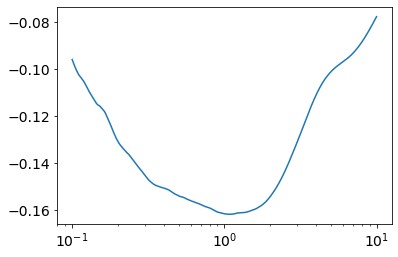

In [61]:
#diff = [cv_hist[i] - cv_hist1[i] for i in range (len(cv_hist))]
plt.plot(h_list_e, cv_hist_e)
#plt.vlines(b,-0.1,25, color= 'r')
plt.xscale("log")

In [62]:
print("Epanechnikov",'\n','h_cv', h_list_e[np.argmin(cv_hist_e)], '\n', 'J', min(cv_hist_e))

Epanechnikov 
 h_cv 1.0716676480328633 
 J -0.16195718898474953


In [63]:
def cross_validation_kernel_gauss(sample, h):
    n = len(sample)
    #sample_min, sample_max = np.min(sample), np.max(sample)
    #bins = np.int(np.ceil((sample_max - sample_min) / h))
    summ = 0
    for i in range(n):
        for j in range(n):
            summ += gaussian_2((samples[i] - samples[j])/h)
    summ = summ/(h*n**2)
    summ = summ + 2*gaussian(0)/(h * n_samples) 
    return summ

In [64]:
h_list1 = np.logspace(-1,1, 500)

cv_hist2 = [cross_validation_kernel_gauss(samples, hi) for hi in h_list1]

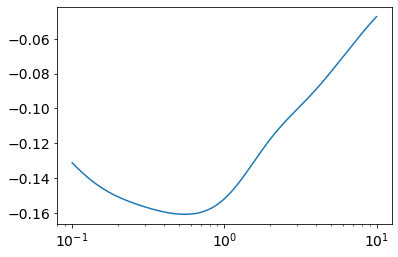

In [65]:
#diff = [cv_hist[i] - cv_hist1[i] for i in range (len(cv_hist))]
plt.plot(h_list1, cv_hist2)
#plt.vlines(b,-0.1,25, color= 'r')
plt.xscale("log")

In [66]:
print("gaussian",'\n','h_cv', h_list1[np.argmin(cv_hist2)], '\n', 'J', min(cv_hist2))

gaussian 
 h_cv 0.5514205739240301 
 J -0.16097291011372225


3. Recall the approximation to $MISE$ from Lecture 7, slide 20. Assume an Oracle calculated the integral of the squared second derivative of the true density for you and the value is $0.127529$. What will be the approximate optimal bandwidth $h^*$? Find CV estimate of $J$ for this value of bandwidth and compare it to the one found in part 1 (0.5 point)

In [67]:
const = 0.127529
#https://www.wolframalpha.com/input/?i=integrate+from+-1+to+1+%28x**2+*+3*%281-x%5E2%29%2F4%29
I_sq = 0.2
#https://www.wolframalpha.com/input/?i=integrate+from+-1+to+1+%283*%281-x%5E2%29%2F4%29**2
I_n = 0.6
h_b = (I_n/ (len(samples) * (I_sq)**2 * const))**(1/5)
print('h_cv', h_b, '\n', 'J', cross_validation_kernel_epach(samples, h_b))

h_cv 1.032990817433772 
 J -0.16186474741324025


# Task 2. Non-parametric Regression (5.5 pt)

In this task you will apply non-parametric regression to airport statistics data.

### Data loading and preprocessing

Load dataset from `airport_operations_report.csv`. Use `General Aviation: Total Operations` as target(dependent) variable and `[Air Carrier Operations, General Aviation: Local Operations]` as covariates(independent variables). Divide $1^{st}$ covariate by `1000`, $2^{nd}$ by `100` and target by `1000`. Make 2D grid for covariates from minimum to maximum values with `100` steps along each dimension.

In [68]:
import pandas as pd
data_a = pd.read_csv("airport_operations_report.csv")
data_a.head()

,Air Carrier Operations,General Aviation: Local Operations,General Aviation: Total Operations
0,10329.0,4.0,2219.0
1,10593.0,28.0,3312.0
2,11320.0,56.0,3310.0
3,11936.0,0.0,3382.0
4,11726.0,256.0,4242.0


In [69]:
data_a['Air Carrier Operations'] = data_a['Air Carrier Operations']/1000
data_a['General Aviation: Local Operations'] = data_a['General Aviation: Local Operations']/100
data_a['General Aviation: Total Operations'] = data_a['General Aviation: Total Operations']/1000
data_a.head()

,Air Carrier Operations,General Aviation: Local Operations,General Aviation: Total Operations
0,10.329,0.04,2.219
1,10.593,0.28,3.312
2,11.320,0.56,3.310
3,11.936,0.00,3.382
4,11.726,2.56,4.242


In [70]:
x1 = np.array(data_a['Air Carrier Operations'])
x2 = np.array(data_a['General Aviation: Local Operations'])

In [71]:
xx = np.linspace(min(x1), max(x1), 100)
yy = np.linspace(min(x2), max(x2), 100)

In [72]:
xy_grid, yx_grid = np.meshgrid(xx, yy)

### Fit model (1 pt)

Perform a nonparametric regression to fit the model $Y = f(x)+\varepsilon$. 

In [73]:
target = data_a['General Aviation: Total Operations']
cov= data_a.drop(['General Aviation: Total Operations'], axis=1)

In [74]:
x1 = np.array(data_a['Air Carrier Operations'])
x2 = np.array(data_a['General Aviation: Local Operations'])
order = np.argsort(target)
x1 = x1[order,None]
x2 = x2[order, None]
target = target[order, None]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


In [75]:
# Your code

nw = KernelReg(np.array(target), np.concatenate((x1,x2), axis = 1), var_type="cc", reg_type="lc")


Predict values for created grid.

In [76]:
X_2D = np.c_[xy_grid.ravel(), yx_grid.ravel()]

In [77]:
target_pred, margins = nw.fit(X_2D)

In [78]:
nw.bw

array([0.5371977 , 0.55854071])

This is function to visualize 3D surfaces. You can modify it if you need.

In [79]:
def plot_surface_function(x1, x2, y, minmax_values=None, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        
        surf = ax.plot_surface(x1, x2, y, cmap=cm.rainbow, linewidth=0.5, alpha=0.5, edgecolor="k")
        if minmax_values is not None:
            ax.set_xlim3d(*minmax_values[0])
            ax.set_ylim3d(*minmax_values[1])
    
    else:
        surf = ax.plot_surface(x1, x2, y, cmap=cm.bwr, linewidth=0.5, alpha=0.1, edgecolor="k")
        
    return ax

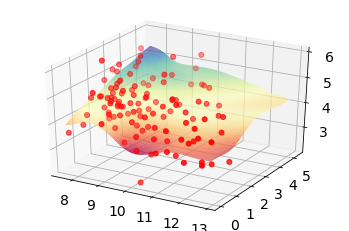

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.plot_trisurf(X_2D[:,0],X_2D[:,1],target_pred, cmap=plt.cm.Spectral)
ax.scatter(x1, x2, np.array(target), marker="o", s=25, c="r")
fig1.show()

Let's plot estimated surface.

### Estimate confidence intervals (2 pt)

Construct 95\% confidence bands for your estimate. To estimate error variance for 1D covariate, you sort your sample and subtract target values in the nearest points. For 2D covariate, you should, for each point, calculate the difference in target values between a point and its nearest neighbor(in euclidian metric). To get power for quantile of standard normal distribution, which is $\frac{w}{b-a}$ for 1D, estimate it per coordinate and multiply: $\prod_{i=1}^2 \frac{w_i}{b_i-a_i}$. 

In [81]:
def prediction_se(grid, sample, target, h, alpha=0.05):
    n = target.shape[0]
    sigma_hat2 = 0
    mask = np.ones(n, dtype=np.bool_)
    for i in range (n):
        mask[i] = False
        nbrs = NearestNeighbors(n_neighbors=1).fit(sample[mask])
        distances, indices = nbrs.kneighbors(sample[i].reshape(1, -1))
        #print(indices)
        index = indices[0][0]

        mask[i] = True
        if index >=i:
            sigma_hat2 += (target[index+1] - target[i])**2
        else:
            sigma_hat2 += (target[index] - target[i])**2
    delta = np.max(sample[:,0]) - np.min(sample[:,0])
    delta1 = np.max(sample[:,1]) - np.min(sample[:,1])

    kernel_values = kernel(grid, sample, h)
    kernel_sum = np.sum(kernel_values, axis=1, keepdims=True)
#     print(kernel_values)

    nonzero_indices = kernel_sum[:, 0] > 1e-8
    kernel_weights = kernel_values
    kernel_weights[nonzero_indices] = kernel_weights[nonzero_indices] / kernel_sum[nonzero_indices]
    kernel_weights[~nonzero_indices] = 0

    se = np.sqrt(np.sum(kernel_weights**2, axis=1) * sigma_hat2*(1/(2*(n-1))))
    #m = delta / (3 * h)
    m = (delta*delta1/(9*h[0]*h[1]))
    q = sps.norm.ppf((1+(1-alpha)**(1/m))/2) 
    return q*se

In [82]:
from sklearn.neighbors import NearestNeighbors
kernel = lambda x, y, h: rbf_kernel(x/h, y/h, 0.5 ) / (2 * np.pi)**(x.shape[1] / 2)
h = nw.bw
qse = prediction_se(X_2D,np.concatenate((x1,x2), axis = 1),target, h, alpha=0.05)
qse = qse.reshape(10000)

In [83]:
X_2D.shape

(10000, 2)

Let's plot confidence intervals

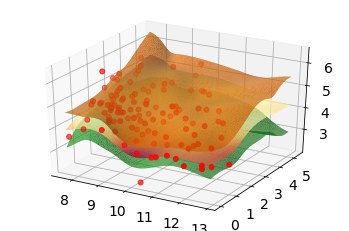

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.plot_trisurf(X_2D[:,0],X_2D[:,1],target_pred, cmap=plt.cm.Spectral)
ax.scatter(x1, x2, np.array(target), marker="o", s=25, c="r")

ax.plot_trisurf(X_2D[:, 0], X_2D[:, 1], target_pred + qse)
ax.plot_trisurf(X_2D[:, 0], X_2D[:, 1], target_pred - qse)
fig1.show()

### Find optimal bandwidth (2 pt)

Use cross-validation to estimate the bandwidth.

In [87]:
def cross_validation_regression(x1,x2, target, h1,h2):
    n = target.shape[0]
    mask = np.ones(n, dtype=np.bool_)
    bw = [h1,h2]
    summ = 0
    for i in range(n):
        mask[i] = False
        nw = KernelReg(target[mask], np.concatenate((x1,x2), axis = 1)[mask], var_type="cc", reg_type="lc", bw=bw)
        mask[i] = True
        summ += (target[i] - nw.fit(np.concatenate((x1,x2), axis = 1)[i].reshape(2, 1))[0])**2
    return summ.item()

In [88]:
h_list = np.logspace(-1, 1, 51)
hxy, hyx = np.meshgrid(h_list, h_list)
h_2D = np.c_[hxy.ravel(), hyx.ravel()]

In [89]:

cv_hist = np.array([cross_validation_regression(x1,x2, target, h_2D[hi,0],h_2D[hi,1]) for hi in range(len(h_2D))])

In [90]:
cv_hist

array([47.60869454, 47.23026231, 47.23428172, ..., 43.57719753,
       43.65131292, 43.71357517])

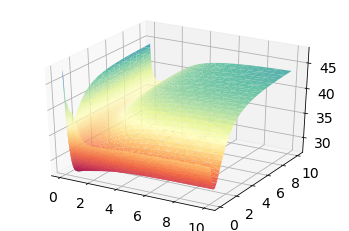

In [91]:
%matplotlib inline
fig1 = plt.figure()
ax = fig1.gca(projection='3d')
ax.plot_trisurf(h_2D[:len(cv_hist),0],h_2D[:len(cv_hist),1],cv_hist, cmap=plt.cm.Spectral)
#ax.scatter(np.array(cov)[:, 0], np.array(cov)[:, 1], np.array(target), marker="o", s=25, c="r")
fig1.show()

In [92]:
h_2D[np.argmin(cv_hist)]

array([0.52480746, 0.57543994])

Make grid with logarithm step to find best bandwidth, from `0.1` to `10` with `21` steps along each dimension. Visualize obrained results with `plot_surface_function`. Print values for optimal bandwidth.

Plot surface with estimated bandwidth.

### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

We can take more point for search and it will wimporove or searching (but take really long time)

In this task we tried to implement non-parametric regression and estimate confidence interval and for h we take the results from or model.

As we can see the results from our model not very far from cv search.

# Task 3. Model Selection (5.5 pt)

In this task you will select model(choose set of covariates) using AIC criteria and forward/backward stepwise regression.

### Data loading and preprocessing

Read dataset `pacn_wrcc.csv`. The target variable is `ly Solar Rad.`, others are covariates.

In [93]:
# Your code
import pandas as pd
data = pd.read_csv("pacn_wrcc.csv")

In [94]:
np.array(data.columns)

array(['mph Wind Speed', 'Deg Wind Direc', 'Deg F Av Air Temp',
       '% Rel Humidty', 'volts Battery Voltage', 'Deg Dir MxGust',
       'mph Mx Gust Speed', 'ly Solar Rad.', 'Deg F Mn Air Temp',
       'Deg F Mx Air Temp', 'Deg F 2" Soil Ave Tmp',
       'Deg F 4" Soil Ave Tmp', 'Deg F 8" Soil Av Temp',
       'Deg F 20"Soil Av Temp'], dtype=object)

Scale covariates to range `[0, 1]` and add bias column.

In [95]:
target = data['ly Solar Rad.']
covar = data.drop(['ly Solar Rad.'], axis = 1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = covar.columns
covar_scaled = scaler.fit_transform(np.array(covar))
bias = np.ones(covar.shape[0])
covar_scaled1 = pd.DataFrame(covar_scaled, columns = columns)
covar_scaled1['bias'] = np.ones(covar.shape[0])
covar_scaled_1 = np.array(covar_scaled1)

### AIC and sample variance (2 pt) 

Estimate sample variance of error with full set of covariates. Take into account number of dependent variables.

In [96]:
def sigma_s(X,y):
    beta = np.linalg.inv((X.T).dot(X)).dot(X.T).dot(y)
    e = y - X.dot(beta)
    #print(y)
    return np.sum(e**2)/(X.shape[0] - X.shape[1])
    

In [97]:
sigma2 = sigma_s(covar_scaled1,np.array(target))
sigma2

28.541679347084557

Implement estimate of AIC for given covariates, target and error variance.

$AIC = |l_s| - |S|$



In [98]:
def aic(X, y, sigma2):
    n = X.shape[0]
    beta =  np.linalg.inv(X.T @ X) @ X.T @ y
    res = (X.dot(beta) - y)
    l = -n*np.log(np.sqrt(2 * np.pi*sigma2)) - 1/(2*sigma2)*np.sum(res**2)
    aic = l - X.shape[1]
    return aic


In [99]:
aic(covar_scaled_1,np.array(target), sigma2) 

-935.3863777901413

### Forward stepwise regression (1 pt)

Implement forward stepwise regression. Save the order in which covariates are added to feature set and AIC values for those feature sets.

In [100]:
def forward_stepwise_regression(X,columns, y, sigma2, alpha=0.):
    AIC_final = []
    features_name = []
    max_aic = -np.inf
    cols = [i for i in range (X.shape[1])]
    while len(features_name) <= 13:
        AIC = []
        for item in cols:
            c = features_name.copy()
            c.append(item)
            AIC.append(aic(X[:,c], y, sigma2))
        if (max_aic > max(AIC)):
            break
        max_aic = max(AIC)
        AIC_final.append(max_aic)
        a = np.argmax(AIC)
        features_name.append(cols[a])
        cols.remove(cols[a])
        #print(cols,a)
    return features_name, AIC_final

In [101]:
columns = (covar.columns)
features, aic_list = forward_stepwise_regression(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} +{features[:a]}")

AIC -1394.864 +[8]
AIC -1077.883 +[8, 3]
AIC -1020.663 +[8, 3, 4]
AIC -981.245 +[8, 3, 4, 6]
AIC -956.233 +[8, 3, 4, 6, 10]
AIC -947.323 +[8, 3, 4, 6, 10, 2]
AIC -936.352 +[8, 3, 4, 6, 10, 2, 7]
AIC -935.844 +[8, 3, 4, 6, 10, 2, 7, 1]
AIC -935.713 +[8, 3, 4, 6, 10, 2, 7, 1, 9]
AIC -932.145 +[8, 3, 4, 6, 10, 2, 7, 1, 9, 12]


### Backward stepwise regression (1 pt)

Implement backward stepwise regression. Save the order in which covariates are removed from feature set and AIC values for those feature sets.

In [102]:
def backward_stepwise_regression(X,columns, y, sigma2, alpha=0.):
    AIC_final = []
    features_name_r = []
    cols_names = columns
    cols = [i for i in range (X.shape[1])]
    max_aic = (aic(np.array(X), y, sigma2))
    while (len(features_name_r) <= 12):
        AIC = []
        for i in cols:
            c =  cols.copy()
            c.remove(i)
            AIC.append(aic(X[:,c], y, sigma2))
            x = 0
        if (max_aic > max((np.array(AIC)))):
            break
        a = np.argmax((np.array(AIC)))

        max_aic = max((np.array(AIC)))

        AIC_final.append(max_aic)
        features_name_r.append(cols[a])
        cols.remove(cols[a])

    return features_name_r, AIC_final

In [103]:
columns = (covar.columns)
features, aic_list = backward_stepwise_regression(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)
print(features,aic_list)
for a, aic_value in enumerate(aic_list, 1):
    print(f"AIC {aic_value:.3f} -{features[:a]}")

[0, 11, 5, 13] [-934.4040383610643, -933.526203876554, -932.8494719467101, -932.1453404327832]
AIC -934.404 -[0]
AIC -933.526 -[0, 11]
AIC -932.849 -[0, 11, 5]
AIC -932.145 -[0, 11, 5, 13]


### Bruteforce (1 pt)

Find best sets of covariates and their AIC for all sizes of feature sets.

In [104]:
!pip install more-itertools

In [105]:
def bruteforce(X,columns, y, sigma2, alpha=0.):
    features_name = []
    AIC_final = []
    max_aic = -np.inf
    for i in range(X.shape[1]):
        AIC = 0
        list_of_i = []
        for item in itertools.combinations(np.arange(X.shape[1]), i):
            AIC=(aic(X[:,list(item)], y, sigma2))
            if max_aic < AIC:
                max_aic = AIC
                features_name.append(list(item))
                AIC_final.append(max_aic)
        
    return features_name, AIC_final


In [106]:
import itertools
features, aic_list = bruteforce(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)
for a, aic_value in enumerate(aic_list):
    print(f"AIC {aic_value:.3f} -{features[a]}")

AIC -3117.563 -[]
AIC -2463.586 -[0]
AIC -1487.838 -[2]
AIC -1394.864 -[8]
AIC -1369.194 -[0, 2]
AIC -1285.593 -[0, 8]
AIC -1094.295 -[2, 3]
AIC -1077.883 -[3, 8]
AIC -1068.087 -[0, 3, 8]
AIC -1016.492 -[2, 3, 4]
AIC -1005.003 -[0, 2, 3, 4]
AIC -978.614 -[2, 3, 4, 6]
AIC -977.517 -[0, 2, 3, 4, 6]
AIC -958.246 -[0, 2, 3, 4, 10]
AIC -946.324 -[2, 3, 4, 6, 10]
AIC -944.891 -[1, 2, 3, 4, 6, 10]
AIC -940.191 -[2, 3, 4, 6, 7, 10]
AIC -939.711 -[1, 2, 3, 4, 6, 7, 10]
AIC -936.352 -[2, 3, 4, 6, 7, 8, 10]
AIC -935.844 -[1, 2, 3, 4, 6, 7, 8, 10]
AIC -935.713 -[1, 2, 3, 4, 6, 7, 8, 9, 10]
AIC -933.475 -[2, 3, 4, 6, 7, 8, 9, 10, 11]
AIC -932.943 -[2, 3, 4, 6, 7, 8, 9, 10, 12]
AIC -932.145 -[1, 2, 3, 4, 6, 7, 8, 9, 10, 12]


In [107]:
%timeit bruteforce(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)

1 loop, best of 3: 1.19 s per loop


In [108]:
%timeit backward_stepwise_regression(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)

100 loops, best of 3: 5.62 ms per loop


In [109]:
%timeit forward_stepwise_regression(covar_scaled_1, columns,np.array(target), sigma2, alpha=0)

100 loops, best of 3: 7 ms per loop


### Conclusion (0.5 pt)

Write your conclusions about conducted experiments (2-5 sentence).

As we can see all 3 methods leads to the same result as it was expected.

But brutforce took more time than the others as we can see from the results above (backward and forward steps were close to each other)

# Task 4. Local regression (6 points)

In [110]:
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.linear_model import LogisticRegression

In [111]:
X = np.array([-3.        , -2.93939394, -2.87878788, -2.81818182, -2.75757576,
       -2.6969697 , -2.63636364, -2.57575758, -2.51515152, -2.45454545,
       -2.39393939, -2.33333333, -2.27272727, -2.21212121, -2.15151515,
       -2.09090909, -2.03030303, -1.96969697, -1.90909091, -1.84848485,
       -1.78787879, -1.72727273, -1.66666667, -1.60606061, -1.54545455,
       -1.48484848, -1.42424242, -1.36363636, -1.3030303 , -1.24242424,
       -1.18181818, -1.12121212, -1.06060606, -1.        , -0.93939394,
       -0.87878788, -0.81818182, -0.75757576, -0.6969697 , -0.63636364,
       -0.57575758, -0.51515152, -0.45454545, -0.39393939, -0.33333333,
       -0.27272727, -0.21212121, -0.15151515, -0.09090909, -0.03030303,
        0.03030303,  0.09090909,  0.15151515,  0.21212121,  0.27272727,
        0.33333333,  0.39393939,  0.45454545,  0.51515152,  0.57575758,
        0.63636364,  0.6969697 ,  0.75757576,  0.81818182,  0.87878788,
        0.93939394,  1.        ,  1.06060606,  1.12121212,  1.18181818,
        1.24242424,  1.3030303 ,  1.36363636,  1.42424242,  1.48484848,
        1.54545455,  1.60606061,  1.66666667,  1.72727273,  1.78787879,
        1.84848485,  1.90909091,  1.96969697,  2.03030303,  2.09090909,
        2.15151515,  2.21212121,  2.27272727,  2.33333333,  2.39393939,
        2.45454545,  2.51515152,  2.57575758,  2.63636364,  2.6969697 ,
        2.75757576,  2.81818182,  2.87878788,  2.93939394,  3.        ])

In [112]:
Y = np.array([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

You are given a sample of pairs $(X_i, Y_i)$. The output variable appers to be binary. We know a model for this type of data: logistic regression. In this model we assume the log-odds of the Bernoulli output variable to be a linear function:
$$\mathbb{P}(Y_i = 1 | X_i = x_i) = p(x_i) = \frac{e^{\beta_0 + \beta_1 x_i}}{1 + e^{\beta_0 + \beta_1 x_i}}$$
Lets fit a standard logistic regression to the data:

In [113]:
logreg = LogisticRegression(penalty='none')
logreg.fit(X.reshape(-1, 1), Y)
p_pred_global = logreg.predict_proba(X.reshape(-1, 1))[:, 1]
print(f"Coefficients of the fitted logistic regression model: b0={logreg.intercept_[0]}, b1={logreg.coef_[0][0]}")

Coefficients of the fitted logistic regression model: b0=0.3769839468432626, b1=0.9109286874944


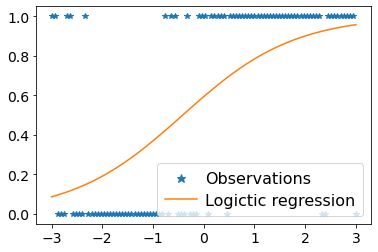

In [114]:
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.legend()

## Local regression

As we can see, the dependence of the outcome on $x$ looks more complex than estimated using logistic regression. We will try to improve it with local regression methods instead.
Instead of a global model, we will approximate conditinal probability of the positive class in a neighbourhood of $x$ with:
$$p(u) \approx \frac{e^{\beta_0 + \beta_1 (u-x) }}{1 + e^{\beta_0 + \beta_1 (u-x)}}, $$
for $u$ close to $x$. The coefficients in this case will depend on $x$. To find them, we will have to fit a (slightly different) model at each new query point $x_{new}$ (point where we want to predict $Y$). We will also need to introduce a notion of 'closenes' of points across $x$ - for this we can use our familiar *kernel functions*. Bringing everything together, we introduce the following local loglikelihood for our proposed model:
$$\ell_x(\beta) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right)\ell\left(Y_i, \beta_0 + \beta_1 \left(X_i - x\right)\right) = \sum\limits_{i=1}^{n} K\left(\frac{x-X_i}{h}\right) \left(Y_i \left(\beta_0 + \beta_1 \left(X_i - x\right)\right) - \log \left( 1 + e^{\beta_0 + \beta_1 \left(X_i - x\right)} \right) \right),$$
$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$
Here $\ell(y, z)$ is a log-likelohood for a single Bernoulli with log-dds ratio $z = \frac{p}{1-p}$. The local log-likelihood $\ell_x(\beta)$ should be optimized numerically to each new point $x$ to obtain $\widehat{\beta}(x)=(\widehat{\beta_0}(x), \widehat{\beta_1}(x))$. Then, we can predict $Y$ using the logistic model:
$$ \mathbb{P}(Y=1 | X=x) = \frac{e^{\beta_0(x)}}{1 + e^{\beta_0(x)}}.$$
Your task is:
1. Implement the proposed local logistic regression approach using Gaussian kernel. *Hint*: look at additional parameters of the `fit` method of [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) from `sklearn` package (2 points)
2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)
3. Now ignore that the output variable is binary. Compare previous results with local linear kernel regression method using `KernelReg` from `statsmodels`. Use leave-one out squared error cross-validation to select the bandwidth (1 bonus point)

In [216]:
def kernel(x,y,h):
  return rbf_kernel(x,y,1/(2*h**2))/(2*np.pi)**(x.shape[1]/2)

def loc_log(X,Y,h):
  kernell = kernel(X.reshape(-1,1), X.reshape(-1,1),h)
  print(kernell)
  i = 0
  p = np.zeros(X.shape[0])
  
  for x in X:
    logreg = LogisticRegression(penalty='none')
    logreg.fit((X-x).reshape(-1, 1), Y, sample_weight=kernell[i])
    b0 = logreg.intercept_[0]
    b1  = logreg.coef_[0][0]
    p[i] = np.exp(b0)/(1+np.exp(b0))
    i += 1
  return p



In [217]:
p_pred_local = loc_log(X,Y,h=1/2)
p_pred_local1 = loc_log(X,Y,h=1/10)
p_pred_local2= loc_log(X,Y,h=1)

[[3.98942280e-01 3.96022313e-01 3.87390020e-01 ... 3.82250311e-31
  9.12468788e-32 2.14638374e-32]
 [3.96022313e-01 3.98942280e-01 3.96022313e-01 ... 1.57796316e-30
  3.82250311e-31 9.12468788e-32]
 [3.87390020e-01 3.96022313e-01 3.98942280e-01 ... 6.41896566e-30
  1.57796316e-30 3.82250311e-31]
 ...
 [3.82250311e-31 1.57796316e-30 6.41896566e-30 ... 3.98942280e-01
  3.96022313e-01 3.87390020e-01]
 [9.12468788e-32 3.82250311e-31 1.57796316e-30 ... 3.96022313e-01
  3.98942280e-01 3.96022313e-01]
 [2.14638374e-32 9.12468788e-32 3.82250311e-31 ... 3.87390020e-01
  3.96022313e-01 3.98942280e-01]]
[[0.39894228 0.33200898 0.19136792 ... 0.         0.         0.        ]
 [0.33200898 0.39894228 0.33200898 ... 0.         0.         0.        ]
 [0.19136792 0.33200898 0.39894228 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.39894228 0.33200898 0.19136792]
 [0.         0.         0.         ... 0.33200898 0.39894228 0.33200898]
 [0.         0.         0.    

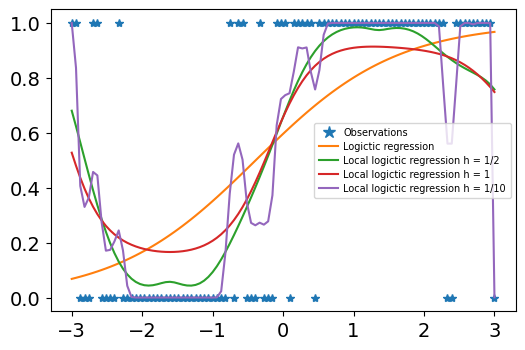

In [219]:
plt.figure(dpi = 100)
plt.plot(X, Y, '*', label='Observations')
plt.plot(X, p_pred_global, label='Logictic regression')
plt.plot(X, p_pred_local, label='Local logictic regression h = 1/2')
plt.plot(X, p_pred_local2, label='Local logictic regression h = 1')
plt.plot(X, p_pred_local1, label='Local logictic regression h = 1/10')
plt.legend(fontsize = 7)

2. Select optimal bandwidth using leave-one-out log-likelihood cross-validation: $\ell_{cv} = \sum_i \ell(Y_i, \widehat{z}_{-i}(x_i))$, where $\widehat{z}_{-i}$ is the estimated log-odds ratio without $i$th sample (3 points)

$$\ell(y, z) = yz - \log \left(1 + e^z \right).$$

log-dds ratio $z = \frac{p}{1-p}$. 

In [211]:
def l(y,z):
  return y*z - np.log(1+np.exp(z))

def cros_val(X,Y,h):
  n = X.shape[0]
  mask = np.ones(n, dtype=np.bool_)
  l_cv = 0
  for i in range(n):
    mask[i] = False
   
    l_cv += l(Y[i],loc_log(X[mask],Y[mask],h)[i-1])
    
    mask[i] = True
    
  return l_cv

In [214]:
h_list = np.logspace(-2, 1, 10)
l_cv = []
for hi in h_list:
 s = cros_val(X,Y,hi)
 print(hi,s)
 l_cv.append(s)

0.01 -58.044489731539954
0.021544346900318832 -58.044407004602554
0.046415888336127774 -57.9007426634511
0.1 -58.45355276171644
0.21544346900318834 -58.54844862776918
0.46415888336127775 -58.6150683264975
1.0 -60.40000045716248
2.154434690031882 -60.53710558816068
4.6415888336127775 -61.02631496911828
10.0 -61.2289954241479


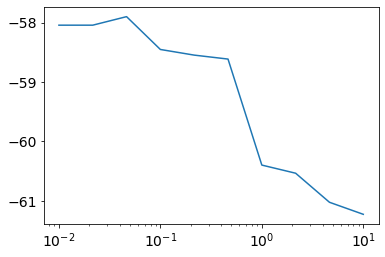

In [215]:
plt.plot(h_list, l_cv)
plt.xscale("log")